# First simulation test for stellar streams with GALA

Part 1 : one star orbit

In [1]:
# %matplotlib widget
%matplotlib inline
import astropy.units as u
import numpy as np
import gala.potential as gp
import matplotlib.pyplot as plt
import gala.dynamics as gd

In [2]:
mw = gp.MilkyWayPotential()

xyz = [-8., 0, 0] * u.kpc

xyz.to(u.km)

E = mw.energy(xyz)
a = mw.acceleration(xyz)
E = E.to((u.km/u.s)**2)  
a = a.to(u.km/u.s / u.Myr)

# print(E)
# print(a)


w0 = gd.PhaseSpacePosition(pos=[-8.1, 0, 0.02] * u.kpc,

                           vel=[13, 245, 8.] * u.km/u.s)

orbit = mw.integrate_orbit(w0, dt=1*u.Myr, t1=0, t2=0.5*u.Gyr)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


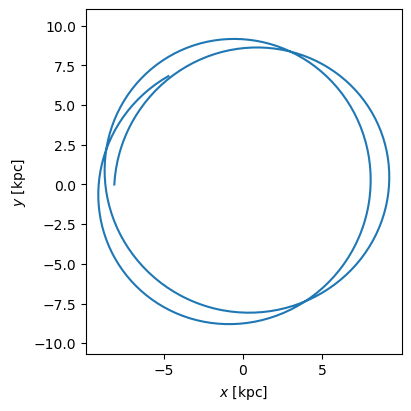

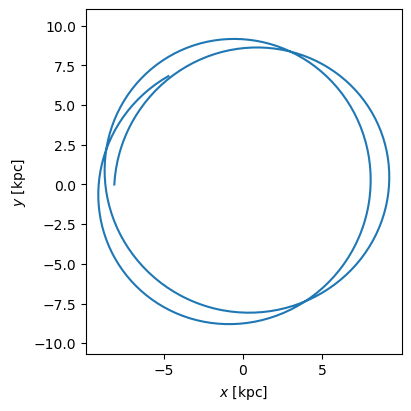

In [3]:
###2D plot
orbit.plot(['x', 'y']) 

(<Figure size 600x600 with 1 Axes>,
 <Axes3D: xlabel='$x$ [$\\mathrm{kpc}$]', ylabel='$y$ [$\\mathrm{kpc}$]', zlabel='$z$ [$\\mathrm{kpc}$]'>)

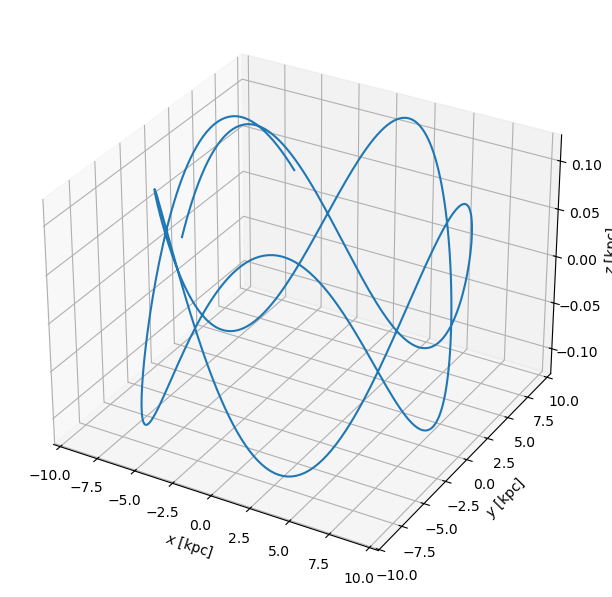

In [4]:
###3D plot

orbit.plot_3d(['x', 'y', 'z'])

# ax = plt.figure().add_subplot(projection='3d')

# ax.plot(x, y, z, label='parametric curve')
# ax.legend()

# plt.show()


Part 2: Generating a mock stellar stream

In [5]:
#Init
import astropy.coordinates as coord
import gala.potential as gp
import astropy.units as u
from gala.units import galactic
from gala.dynamics import mockstream as ms

with coord.galactocentric_frame_defaults.set("v4.0"):
    galcen_frame = coord.Galactocentric()
galcen_frame


<Galactocentric Frame (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg)>

In [6]:
#Create potential
pot = gp.CCompositePotential()

pot['disk'] = gp.MiyamotoNagaiPotential(m=6E10*u.Msun,

                                        a=3.5*u.kpc, b=280*u.pc,

                                        units=galactic)

pot['halo'] = gp.NFWPotential(m=7E11, r_s=15*u.kpc, units=galactic)

In [7]:
#Define ICRS coordinates for Pal5
c = coord.ICRS(ra=229 * u.deg, dec=-0.124 * u.deg,

               distance=22.9 * u.kpc,

               pm_ra_cosdec=-2.296 * u.mas/u.yr,

               pm_dec=-2.257 * u.mas/u.yr,

               radial_velocity=-58.7 * u.km/u.s)

#in galacticcooridnate
c_gc = c.transform_to(galcen_frame)

c_gc.cartesian

pal5_w0 = gd.PhaseSpacePosition(c_gc)
pal5_w0

<PhaseSpacePosition cartesian, dim=3, shape=()>

In [13]:
#Define pal5 properties
pal5_mass = 2.5e4 * u.Msun

pal5_pot = gp.PlummerPotential(m=pal5_mass, b=4*u.pc, units=galactic)

df = ms.FardalStreamDF()

gen_pal5 = ms.MockStreamGenerator(df, pot,

                                  progenitor_potential=pal5_pot)

pal5_stream, _ = gen_pal5.run(pal5_w0, pal5_mass,

                              dt=-1 * u.Myr, n_steps=4500)

/tmp/ipykernel_43735/1157420112.py:6: GalaDeprecationWarning: The parameter values of the FardalStreamDF have been updated (fixed) to match the parameter values in the final published version of Fardal+2015. For now, this class uses the Gala modified parameter values that have been adopted over the last several years in Gala. In the future, the default behavior of this class will use the Fardal+2015 parameter values instead, breaking backwards compatibility for mock stream simulations. To use the Fardal+2015 parameters now, set gala_modified=False. To continue to use the Gala modified parameter values, set gala_modified=True.
  df = ms.FardalStreamDF()


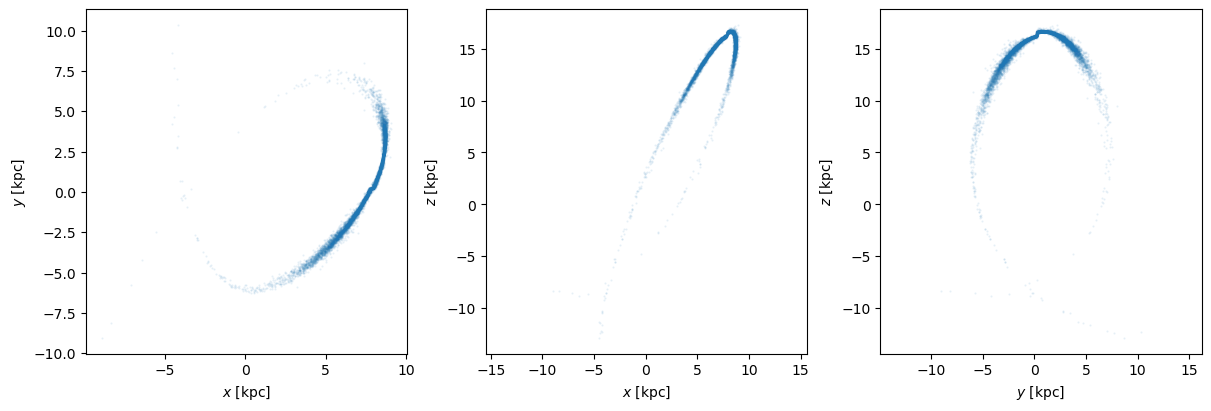

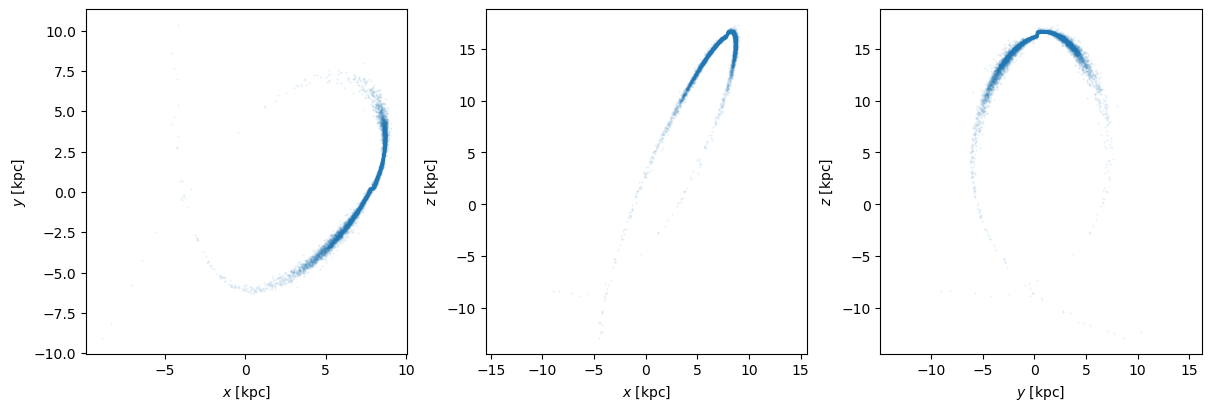

In [14]:
pal5_stream.plot(alpha=0.1, s=1) 



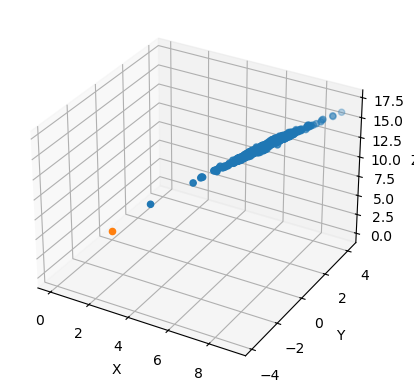

In [10]:
#3D representation

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x, y ,z = pal5_stream.pos.x, pal5_stream.pos.y, pal5_stream.pos.z

ax.scatter(x, y, z)
ax.scatter(0,0,0)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

# N-body simulation

In [15]:
###The Mock stream generator method is too simple regarding the goal of the subject.
#We'll proceed with N-body simulation to seek for observables that could bias the form of the sts,
#and if the position of a star in the stream is related its intrinsic properties
#Here the system is represented by a N-body cluster (globular cluster, let's keep pal5) in a background potential (MW)
%matplotlib widget
import astropy.units as u
import numpy as np
import gala.potential as gp
import matplotlib.pyplot as plt
import gala.dynamics as gd

from gala.dynamics import PhaseSpacePosition
from gala.units import galactic
import astropy.coordinates as coord


with coord.galactocentric_frame_defaults.set("v4.0"):
    galcen_frame = coord.Galactocentric()

In [16]:
###Tests
#Stars
#2-stars with different masses
#Rpal5~23pc

# w0_1 = gd.PhaseSpacePosition(pos=w0_pal5.xyz + [1., 0, 0] * u.pc,
#                              vel=w0_pal5.v_xyz + [0, 5, 0] * u.km/u.s,)
# pot_1 = gp.KeplerPotential(m=10.*u.Msun, units=galactic)
# w0_2 = gd.PhaseSpacePosition(pos=w0_1.xyz+ [1., 0, 0] * u.pc,
#                              vel=w0_1.v_xyz)
# pot_2 = gp.KeplerPotential(m=1.*u.Msun, units=galactic)

In [17]:
###Starting by defining particles and background
##bacground MW
mw_pot = gp.MilkyWayPotential()

##Particles
#Cluster, local background potential
c = coord.ICRS(ra=229 * u.deg, dec=-0.124 * u.deg,
               distance=22.9 * u.kpc,
               pm_ra_cosdec=-2.296 * u.mas/u.yr,
               pm_dec=-2.257 * u.mas/u.yr,
               radial_velocity=-58.7 * u.km/u.s)
c_gc = c.transform_to(galcen_frame)

# print(c_gc.velocity)
# print(c_gc.cartesian)

w0_pal5 = gd.PhaseSpacePosition(c_gc)
pal5_mass = 2.5e4 * u.Msun
pot_Pal_5 = gp.PlummerPotential(m=pal5_mass, b=4*u.pc, units=galactic)

#multiple stars randomly distributed in the cluster
def cluster_stars(cluster_coor, cluster_pot, n_stars, size, velocities):
    w0_stars = [cluster_coor]
    potentials = [cluster_pot]
    for n in range (n_stars):
        #random initial velocities for each star of the cluster
        #in galactic coordinate, for a given star velocity, it is given by Pal5 velocity plus a random angular one
        w0_n = gd.PhaseSpacePosition(pos=w0_pal5.xyz + [size*np.random.randn(), size*np.random.randn(), size*np.random.randn()] * u.pc,
                                vel=w0_pal5.v_xyz + [velocities*np.random.randn(), velocities*np.random.randn(), velocities*np.random.randn()]  * u.km/u.s)
        w0_stars.append(w0_n)
        #pot_n = gp.KeplerPotential(m=(np.random.rand()+1.)*u.Msun, units=galactic)
        potentials.append(None)
        # print(w0_n)
    return w0_stars, potentials





In [18]:
#n stars
w0_stars, potentials = cluster_stars(w0_pal5, pot_Pal_5, 1000, 6, 5)
w0 = gd.combine(w0_stars)
print(w0_stars)

###Integrate orbit
nbody = gd.DirectNBody(w0, potentials, external_potential=mw_pot)

orbits = nbody.integrate_orbit(dt=1e-1*u.Myr, t1=0, t2=5*u.Gyr)


[<PhaseSpacePosition cartesian, dim=3, shape=()>, <PhaseSpacePosition cartesian, dim=3, shape=()>, <PhaseSpacePosition cartesian, dim=3, shape=()>, <PhaseSpacePosition cartesian, dim=3, shape=()>, <PhaseSpacePosition cartesian, dim=3, shape=()>, <PhaseSpacePosition cartesian, dim=3, shape=()>, <PhaseSpacePosition cartesian, dim=3, shape=()>, <PhaseSpacePosition cartesian, dim=3, shape=()>, <PhaseSpacePosition cartesian, dim=3, shape=()>, <PhaseSpacePosition cartesian, dim=3, shape=()>, <PhaseSpacePosition cartesian, dim=3, shape=()>, <PhaseSpacePosition cartesian, dim=3, shape=()>, <PhaseSpacePosition cartesian, dim=3, shape=()>, <PhaseSpacePosition cartesian, dim=3, shape=()>, <PhaseSpacePosition cartesian, dim=3, shape=()>, <PhaseSpacePosition cartesian, dim=3, shape=()>, <PhaseSpacePosition cartesian, dim=3, shape=()>, <PhaseSpacePosition cartesian, dim=3, shape=()>, <PhaseSpacePosition cartesian, dim=3, shape=()>, <PhaseSpacePosition cartesian, dim=3, shape=()>, <PhaseSpacePosition

KeyboardInterrupt: 

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


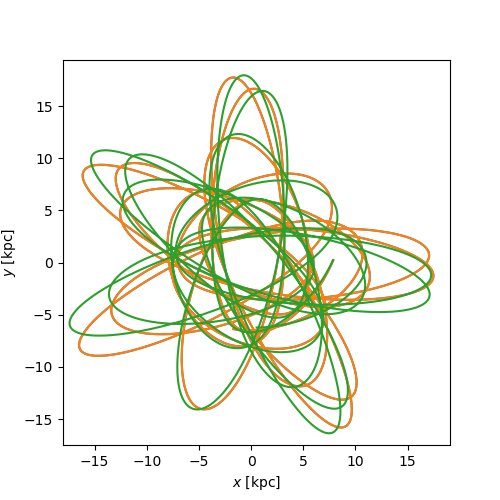

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5)) 

_ = orbits[:, 0].plot(['x', 'y'], axes=[ax]) #Cluster

_ = orbits[:, 1].plot(['x', 'y'], axes=[ax])

_ = orbits[:, 2].plot(['x', 'y'], axes=[ax]) 


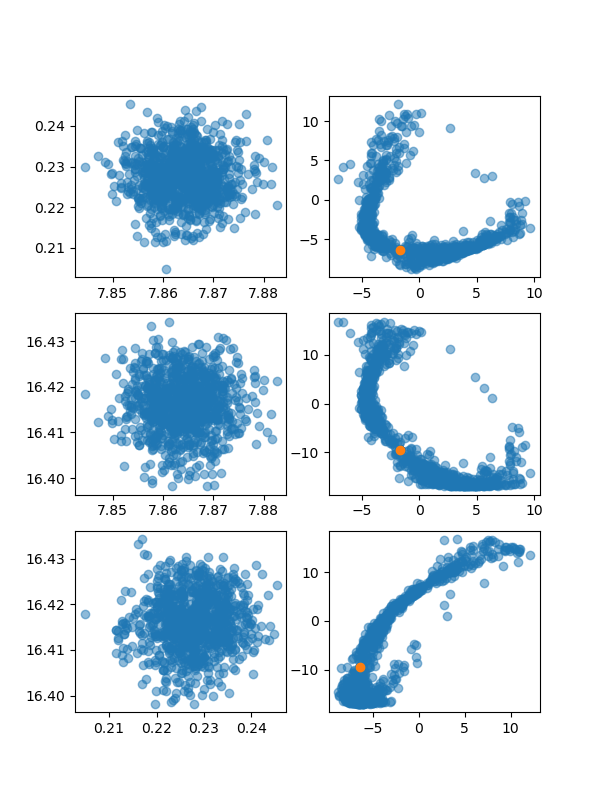

In [17]:
###Plot cluster at the beginning and at the end
#Beginning, initial conidtions
# print(w0.pos.x)
# print(w0.pos.y)
# print(orbits.pos.y[-1])
plt.figure(figsize=(6,8))
#xy
plt.subplot(321)
plt.scatter(w0.pos.x, w0.pos.y, alpha=0.5)#cluster at t0
plt.subplot(322)
plt.scatter(orbits.pos.x[-1], orbits.pos.y[-1], alpha=0.5)#sts
plt.scatter(orbits.pos.x[-1][0], orbits.pos.y[-1][0])#progenitor

#xz
plt.subplot(323)
plt.scatter(w0.pos.x, w0.pos.z, alpha=0.5)
plt.subplot(324)
plt.scatter(orbits.pos.x[-1], orbits.pos.z[-1], alpha=0.5)
plt.scatter(orbits.pos.x[-1][0], orbits.pos.z[-1][0])

#yz
plt.subplot(325)
plt.scatter(w0.pos.y, w0.pos.z, alpha=0.5)
plt.subplot(326)
plt.scatter(orbits.pos.y[-1], orbits.pos.z[-1], alpha=0.5)
plt.scatter(orbits.pos.y[-1][0], orbits.pos.z[-1][0])


plt.show()

Text(0.5, 0, 'Z')

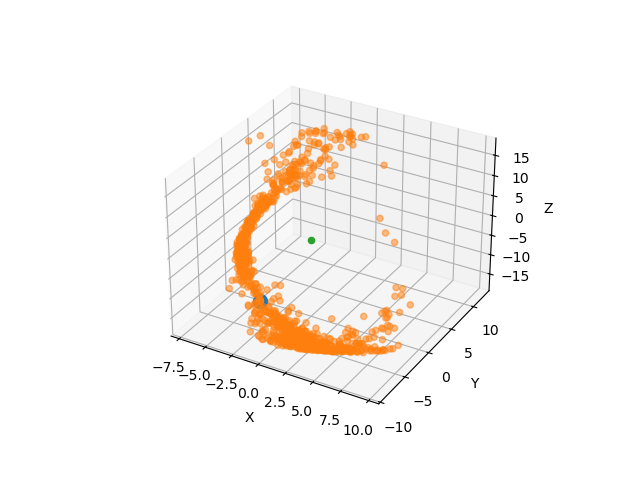

In [18]:
#3D representation

fig3 = plt.figure()
ax3 = fig3.add_subplot(projection='3d')

ax3.scatter(orbits.pos.x[-1][0], orbits.pos.y[-1][0], orbits.pos.z[-1][0], s=100)#progenitor
ax3.scatter(orbits.pos.x[-1], orbits.pos.y[-1], orbits.pos.z[-1], alpha=0.5)#sts
ax3.scatter(0,0,0)#galatic center

ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')